# Description

For defining functional groups and reaction mechanisms for polymerization

# Core Imports

In [ ]:
# Custom Imports
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.reactions import reactions
from polymerist.rdutils.amalgamation import portlib, bonding

from polymerist.monomers.substruct.functgroups import FN_GROUP_TABLE
from polymerist.monomers.substruct import specification


# File I/O
from pathlib import Path
import json

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
# RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH.mkdir(exist_ok=True)

## Defining target functional groups

### Locate base SMARTS to build off of

In [ ]:
gb = FN_GROUP_TABLE.groupby('group_name')
smarts_keys = {
    'hydroxyl'      : ('Hydroxyl', 156),
    'carboxyl'      : ('Carboxylic acid', 51),
    'carbamate'     : ('Carbamate.', 46),
    'acyl_chloride' : ('Acyl Halide', 237),
    'isocyanate'    : ('Cyanamide', 54),
    'ester'         : ('Ester Also hits anhydrides', 58)
}

smarts_dict, mol_dict = {}, {}
for fn_group_name, (group_key, idx) in smarts_keys.items():
    smarts = gb.get_group(group_key).loc[idx].SMARTS
    rdmol = Chem.MolFromSmarts(smarts)

    print(fn_group_name, smarts)
    display(rdmol)

    smarts_dict[fn_group_name] = smarts 
    mol_dict[fn_group_name] = rdmol 

### Define functional groups (with R-group linkers) as basis for desired reactions

In [ ]:
rdkdraw.set_rdkdraw_size(200, 5)

fn_group_smiles_bare = { # TODO : add specificity vis-a-vis bond degree and stereo
    'phthlatimide'   : '[8*]C(=O)N(*)C(=O)*',
    'carbamate'      : '*[NH]C(=O)O*',
    'cyclocarbonate' : '*C1OC(=O)OC1*',
    'anhydride'      : '*C(=O)OC(=O)*',
    'vinyl'          : 'C=C*',
    'acyl_chloride'  : 'Cl-C(=O)*',
    'carboxyl'       : 'OC(=O)*',
    'ester'          : '*OC(=O)*',
    'amine'          : '[NH2]*',
    'hydroxyl'       : '[OH]*',
    'isocyanate'     : 'O=C=N*',
}

fn_groups, fn_group_smiles = {}, {}
for group_name, smiles in fn_group_smiles_bare.items():
    smiles_mol = Chem.MolFromSmiles(smiles)
    smiles_mol = Chem.AddHs(smiles_mol)
    smiles_mol = molwise.assign_ordered_atom_map_nums(smiles_mol, in_place=False)
    display(smiles_mol)

    fn_groups[group_name]       = smiles_mol
    fn_group_smiles[group_name] = Chem.MolToSmiles(smiles_mol)


with (RXN_FILES_PATH / 'fn_group_smarts.json').open('w') as file:
    json.dump(fn_group_smiles, file, indent=4)

# Defining polymerization reactions

In [ ]:
rdkdraw.set_rdkdraw_size(400, 3/2)
rxns, rxn_smarts = {}, {}
portlib.Port.bondable_flavors.insert((1, 2)) # allows for specificity when re-bonding cleaved groups

## Isocyanate polyurethane (IPU) reaction

In [ ]:
# 0) defining targets
chemistry = 'urethane'
reactive_groups = (
    fn_groups['isocyanate'],
    fn_groups['hydroxyl']
)

# 1) extracting and labelling reactants
reactants = molwise.assign_contiguous_atom_map_nums(*reactive_groups, in_place=False)
reactants = Chem.CombineMols(*reactants) 
display(reactants)

In [ ]:
# 2) defining and swapping beonds to form product
bond_remap = {
    7 : (5, 3),
    2 : (3, 5)
}
products = bonding.swap_bonds(Chem.RWMol(reactants), bond_remap, debug_display=True) # create editable Mol
Chem.SanitizeMol(products, sanitizeOps=specification.SANITIZE_AS_KEKULE)
display(products)

# 3) defining reaction
rxn = reactions.AnnotatedReaction.from_rdmols(reactant_templates=[reactants], product_templates=[products])
rxns[chemistry] = rxn
rxn_smarts[chemistry] = rdChemReactions.ReactionToSmarts(rxn)

## NIPU reaction

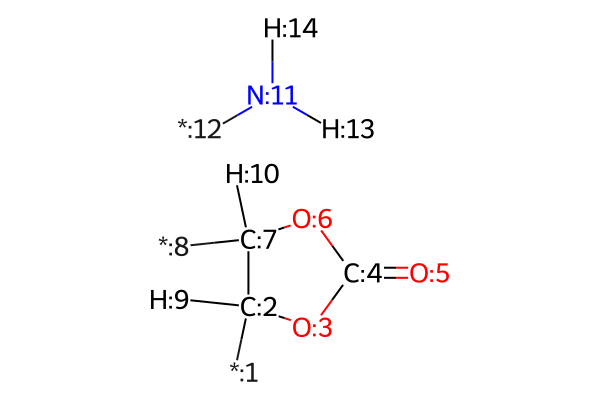

In [12]:
# 0) defining targets
reactive_groups = (
    fn_groups['cyclocarbonate'],
    fn_groups['amine']
)
chemistry = 'NIPU'

# 1) extracting and labelling reactants
reactants = molwise.assign_contiguous_atom_map_nums(*reactive_groups, in_place=False)
reactants = Chem.CombineMols(*reactants) 
display(reactants)

6 --x-> 4


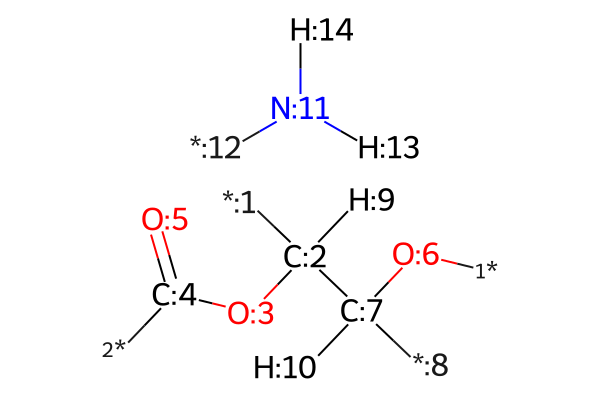

11 --x-> 13


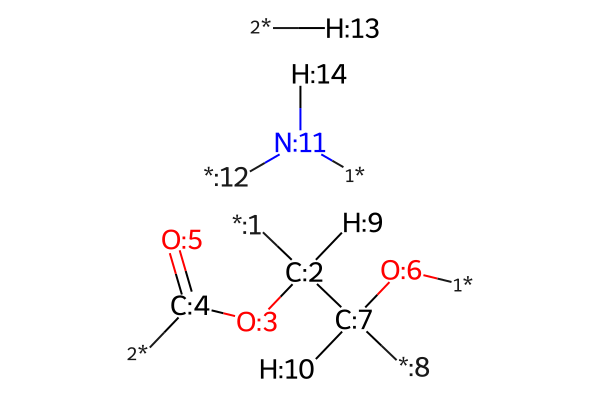

6 ----> 13


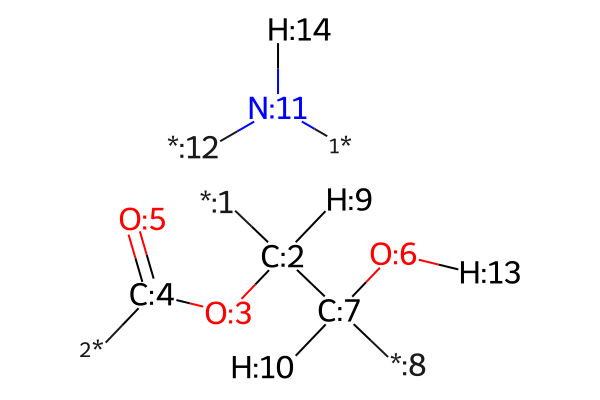

11 ----> 13


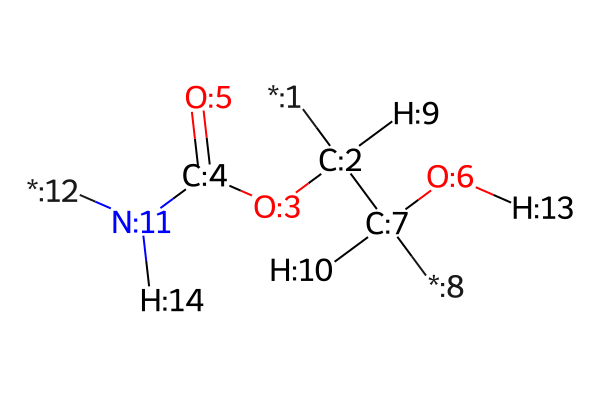

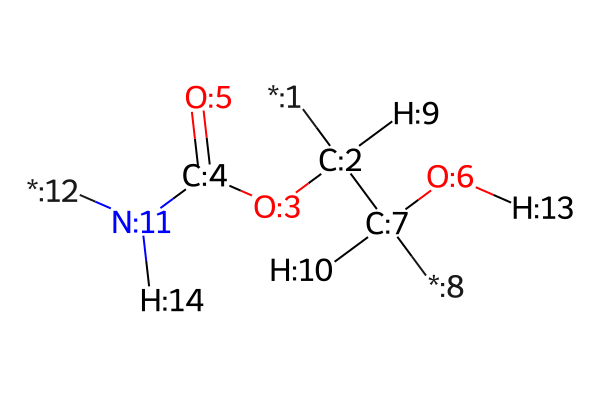

In [14]:
# 2) defining and swapping beonds to form product
bond_remap = {
    6  : (4, 13),
    11 : (13, 4)
}
products = bonding.swap_bonds(Chem.RWMol(reactants), bond_remap, debug_display=True) # create editable Mol
Chem.SanitizeMol(products, sanitizeOps=specification.SANITIZE_AS_KEKULE)
display(products)

# 3) defining reaction
rxn = reactions.AnnotatedReaction.from_rdmols(reactant_templates=[reactants], product_templates=[products])
rxns[chemistry] = rxn
rxn_smarts[chemistry] = rdChemReactions.ReactionToSmarts(rxn)

## Saving SMARTS-based reaction equations to file

In [17]:
with (RXN_FILES_PATH / 'rxn_smarts.json').open('w') as file:
    json.dump(rxn_smarts, file, indent=4)

for chemistry, rxn in rxns.items():
    rxn.to_rxnfile(RXN_FILES_PATH / f'{chemistry}.rxn')